Processing CHIME FRB180916.J0158+65
=====

see CHIME et al. 2020b "Periodic activity from a fast radio burst source"

  0%|          | 0/25 [00:00<?, ?it/s]C:\Users\hmsmo\AppData\Roaming\Python\Python37\site-packages\skimage\measure\block.py:87: RuntimeWarning: Mean of empty slice
  **func_kwargs)
B:\dev\sadtrombone\universal\corrfns.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  temp_array_a[0:nx,:] = result_shifted[nx-1:2*nx-1,:]
B:\dev\sadtrombone\universal\corrfns.py:53: ComplexWarning: Casting complex values to real discards the imaginary part
  temp_array_a[nx:2*nx-1,:] = result_shifted[0:nx-1,:]
100%|██████████| 25/25 [00:01<00:00, 13.50it/s]


,amplitude,xo,yo,sigmax,sigmay,theta,drift (mhz/ms),angle
14,652.595772,64.339470,80.362371,8.604386,2.630998,2.531846,-9.101566,-4.102642
18,2712.615357,64.335281,80.460989,3.211472,14.449416,1.198665,-16.288876,-4.340258
19,1259.786960,64.297873,80.379220,-2.708151,8.573127,4.113518,-9.315770,-7.255111
21,315.106128,64.265050,80.294711,3.815384,8.833964,4.128934,-9.631352,-7.270526
23,4302.700701,64.129710,80.481257,2.061262,13.979090,1.327068,-25.567107,-4.468660
26,3220.300234,63.949668,80.025591,1.322977,0.148178,-0.334902,-18.269033,-1.235894
33,837.493227,64.256824,80.282525,5.766526,2.234116,2.996477,-43.504163,-4.567273
36,3223.528172,63.805382,80.448296,-14.020410,-1.494279,-0.140844,-44.842166,-1.429953


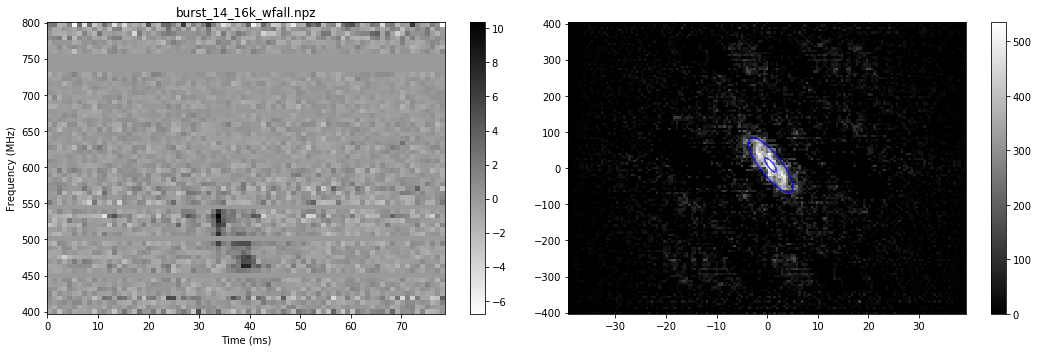

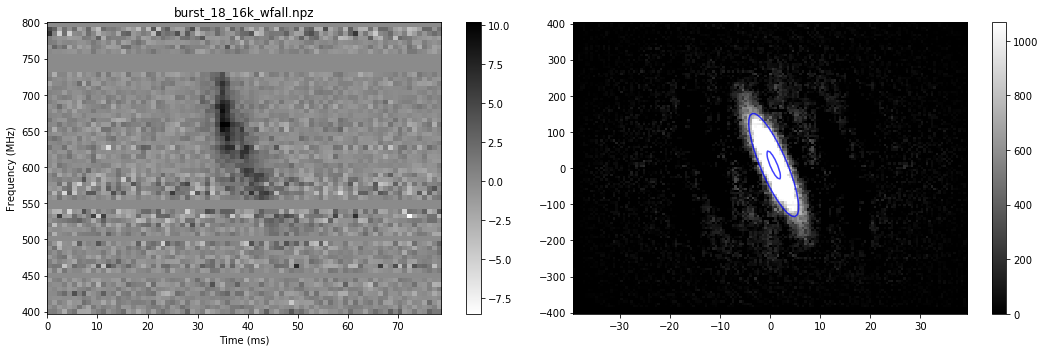

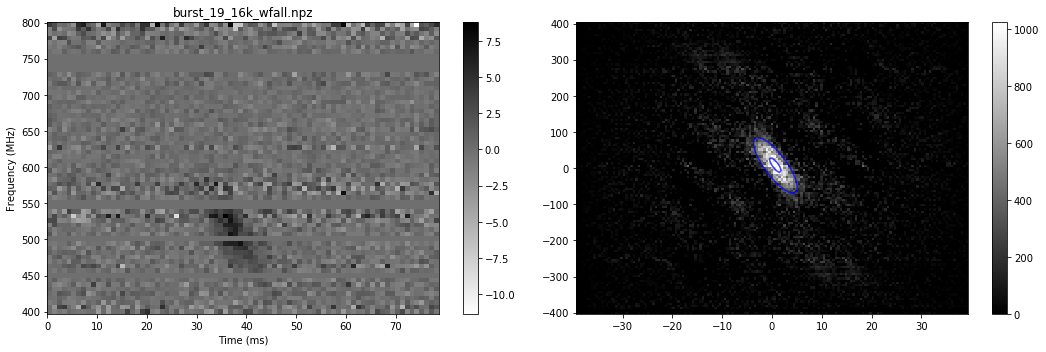

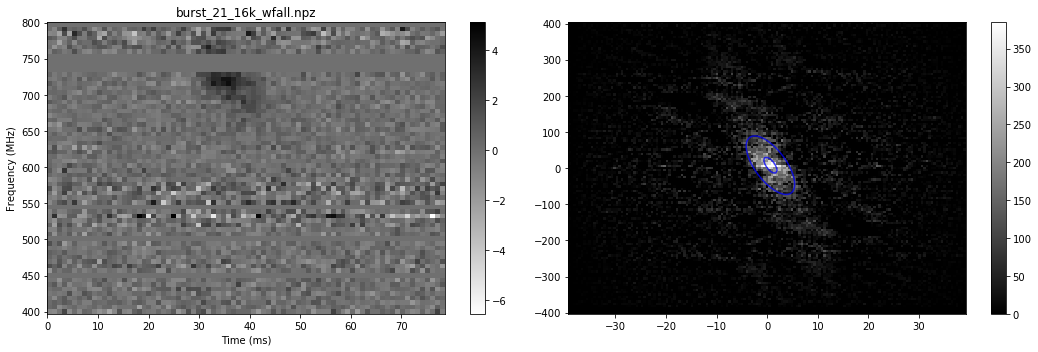

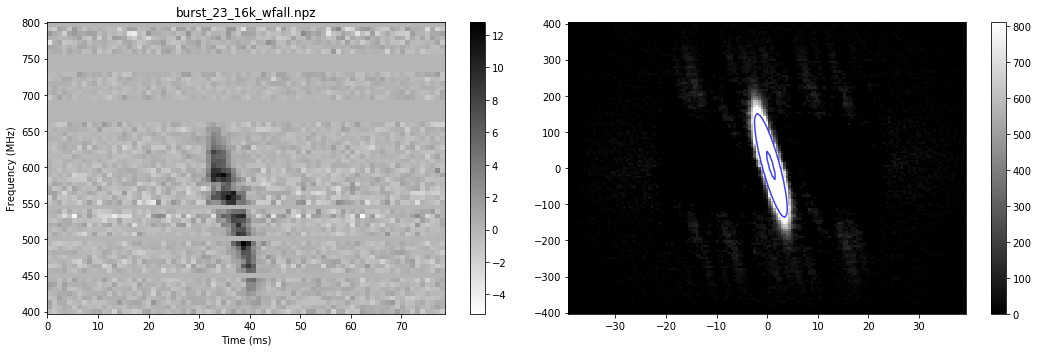

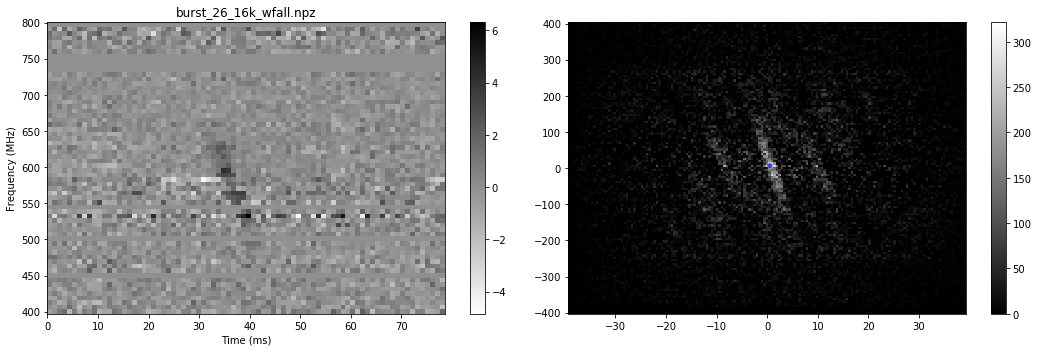

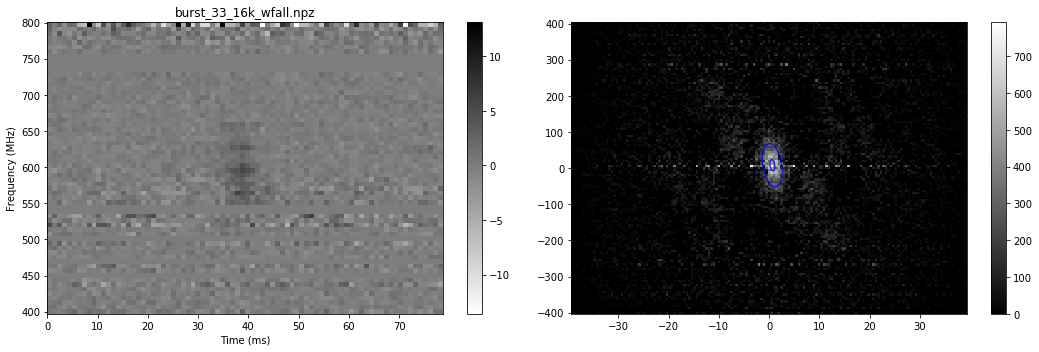

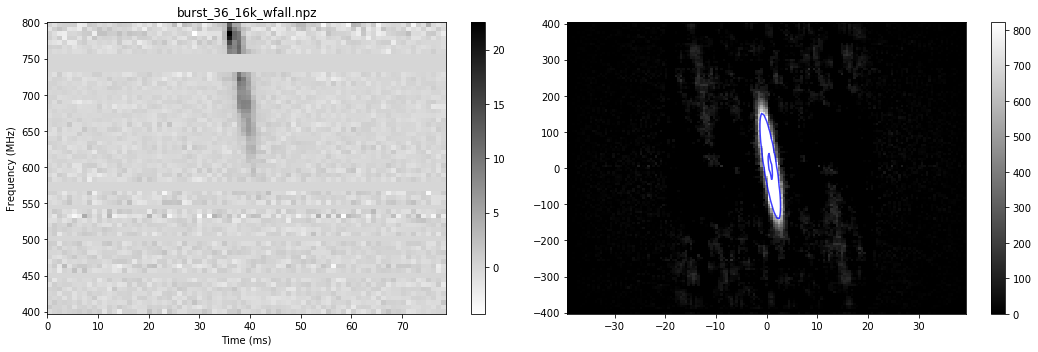

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import os
from tqdm import tqdm
import skimage.measure
import corrfns, fitburst

folder = 'data/CHIME_180916.J0158+65'
burstfiles = [s for s in os.listdir(folder) if '16k' in s]
parameterfile = '{}/chime_180916_fit_params_real.csv'.format(folder)
errorfile     = '{}/chime_180916_param_errors_real.csv'.format(folder)

cmap = plt.get_cmap('gray_r')
cmap.set_bad(color = 'w', alpha = 1.)

if os.path.exists(parameterfile):
    popts = pd.read_csv(parameterfile, index_col=0)
    perrs = pd.read_csv(errorfile, index_col=0)
else:
    popts, perrs = [], []

drifts       = []
drift_errors = []
red_chisqs   = []
angles       = [] # standardize theta to be in [0, pi] 
wellfit      = [14, 18, 19, 21, 23, 26, 33, 36]
multiburst   = [15, 24, 31]

# def getDrift(wfall):

for filename in tqdm(burstfiles):
    data = np.load("{}/{}".format(folder, filename))
    burstnum = int(filename.split('burst_')[1][:2])
    if burstnum not in wellfit and os.path.exists(parameterfile):
        continue
    
    wfall = data["wfall"]
    downsample = 256
    wfall_down = skimage.measure.block_reduce(wfall, block_size=(downsample, 1), func=np.nanmean)
    # print(wfall_down.shape, wfall.shape)
    
    dt_s = data["dt_s"]
    center_freq_mhz = data["center_freq_mhz"]
    df_mhz = center_freq_mhz[1] - center_freq_mhz[0]
    # print(dt_s, center_freq_mhz[0], center_freq_mhz[-1], df_mhz)
    
    burstwindow = wfall_down - wfall_down[:, 0:20].mean(axis=1)[:,None]
    burstwindow = np.nan_to_num(wfall_down)
    ### PROCESS
    
    corr = corrfns.auto_corr2D_viafft(burstwindow)
    #print(burstwindow.shape, corr.shape)
    #### Autocorr noise
    autocorr_sigma = np.std( corr[:, 0:100] )
    # print('autocorr_sigma', autocorr_sigma)
    # auto_sigmas.append(autocorr_sigma)

    #### Fit Gaussian to autocorrelation. Load from parameter file if already found.
    if os.path.exists(parameterfile):
        # print('loading fit...')
        popt, perr = popts.loc[burstnum][:6], perrs.loc[burstnum][:6]
    else:        
        print("finding fit...")
        try:
            popt, pcov = fitburst.fitgaussiannlsq(corr, sigma=autocorr_sigma)
            perr = np.sqrt(np.diag(pcov))
            print('solution nlsq:', popt)
            print('parameter 1sigma:', perr)
            #print('pcov diag:', np.diag(pcov))
        except RuntimeError:
            print('no fit found')
            popt, perr = [-1,-1,-1,-1,-1,-1], [-1,-1,-1,-1,-1,-1]
        popts.append(popt)
        perrs.append(perr)


    x, y = np.meshgrid(range(0, corr.shape[1]), range(0, corr.shape[0]))
    #popt[5] = np.pi/2
    fitmap = fitburst.twoD_Gaussian((y, x), *popt).reshape(corr.shape[0], corr.shape[1])
    
    # calculate reduced chisquared
    residuals = corr - fitmap
    chisq = np.sum((residuals / autocorr_sigma) ** 2)
    red_chisq = chisq / (corr.shape[0]*corr.shape[1] - len(popt)) # this is chisq/(M-N)
    red_chisqs.append(red_chisq)
    # print('reduced chisq:', red_chisq)
    
    # Calculate drifit
    time_res = 0.98304 # ms
    freq_res = 6.25 # MHz
    lowest_freq = 400.20751953125 # MHZ

    theta = -popt[5] - np.pi/2 if abs(popt[3]) > abs(popt[4]) else (-popt[5] - np.pi/2) - np.pi/2
    #print(burstnum, theta, popt[5])
    angles.append(theta) #if theta > 0 else angles.append(theta + 2*np.pi)
    slope = np.tan(theta) 
    conversion = freq_res / (time_res)
    drift = conversion * slope # MHz/ms
    theta_err = perr[-1] # do i need to correct this for pixel scale?
    drift_error = conversion * (theta_err * (1/np.cos(theta))**2) 
    
    drifts.append(drift)
    drift_errors.append(drift_error)
    
    #### Plot
    extents = (0, 
               time_res*burstwindow.shape[1],
               lowest_freq - freq_res/2., 
               lowest_freq + freq_res*burstwindow.shape[0])
    
    corrextents = (-extents[1]/2, extents[1]/2, -(extents[3]-extents[2]), (extents[3]-extents[2]))
    
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.title(filename)
    plt.imshow(burstwindow, aspect='auto', cmap=cmap, extent=extents, origin='lower') # white is 0, black is 1
    
    plt.xlabel("Time (ms)")
    plt.ylabel("Frequency (MHz)")
    plt.colorbar()

    plt.subplot(122)
    plt.imshow(corr, aspect='auto', cmap='gray', extent=corrextents, origin='lower')
    #plt.plot(np.array((400, 600))-popt[1]+popt[2], -slope*(np.array((400, 600)) - popt[1]) +popt[2])
    plt.clim(0, np.max(corr)/10)
    plt.colorbar()
    if popt[0] > 0:
        plt.contour(fitmap, [popt[0]/4, popt[0]*0.9], colors='b', alpha=0.75, extent=corrextents, origin='lower')
        
    ###
    
#     all bursts
#     plt.figure(figsize=(24,24))
#     plt.subplot(5,5,burstfiles.index(filename)+1)
#     plt.title(filename)
#     plt.imshow(wfall_down, origin="lower", aspect="auto", interpolation="nearest", cmap=cmap,
#                extent=(0, 1000*dt_s*wfall.shape[1], center_freq_mhz[0]-df_mhz/2., center_freq_mhz[-1]+df_mhz/2.))
#     plt.colorbar()
#     plt.xlabel("Time [ms]")
#     plt.ylabel("Frequency [MHz]")

    plt.tight_layout()
# plt.savefig('bursts.png')

if not os.path.exists(parameterfile):
    popts = pd.DataFrame(popts, index=[f.split('burst_')[1][:2] for f in burstfiles], columns=['amplitude', 'xo', 'yo', 'sigmax', 'sigmay', 'theta'])
    perrs = pd.DataFrame(perrs, index=[f.split('burst_')[1][:2] for f in burstfiles], columns=['amp_error', 'xo_error', 'yo_error', 'sigmax_error', 'sigmay_error', 'angle_error'])

    try:
        popts['drift (mhz/ms)']       = drifts
        popts['angle']                = angles
        perrs['drift error (mhz/ms)'] = drift_errors
        perrs['red_chisq']            = red_chisqs

        popts.to_csv(parameterfile)
        perrs.to_csv(errorfile)
    except ValueError:
        print('not updating database')
    
    display(popts.loc[wellfit])
else:
    newparams = pd.DataFrame(popts.loc[wellfit], index=wellfit, columns=['amplitude', 'xo', 'yo', 'sigmax', 'sigmay', 'theta', 'drift (mhz/ms)', 'angle'])
    newparams['drift (mhz/ms)']       = drifts
    newparams['angle']                = angles
    display(newparams.loc[wellfit])



### Baseband data

(64, 900)
(64, 900)
(64, 600)
(64, 900)


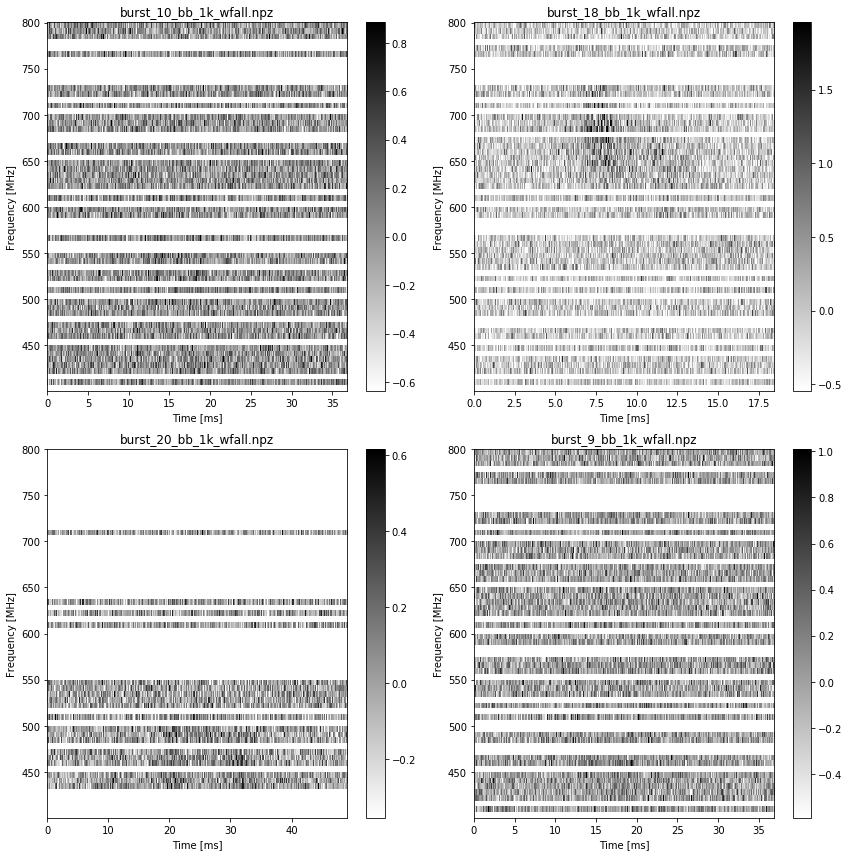

In [58]:
burstfiles = [s for s in os.listdir(folder) if 'bb' in s]

plt.figure(figsize=(12,12))
cmap = plt.get_cmap('gray_r')
cmap.set_bad(color = 'w', alpha = 1.) # potentially hides important errors in the data!

for fname in burstfiles:
    data = np.load("{}/{}".format(folder, fname))
    wfall = data["wfall"]
    wfall_z = np.nan_to_num(wfall)
    
    dt_s = data["dt_s"]
    center_freq_mhz = data["center_freq_mhz"]
    df_mhz = center_freq_mhz[1] - center_freq_mhz[0]
    
    plt.subplot(2,2,burstfiles.index(fname)+1)
 
    bb_downsample = 16
    plt.title(fname)
    plt.imshow(wfall[::16,:], origin="lower", aspect="auto", interpolation="nearest", cmap=cmap,
               extent=(0, 1000*dt_s*wfall.shape[1], center_freq_mhz[0]-df_mhz/2., center_freq_mhz[-1]+df_mhz/2.))
    plt.clim(np.min(wfall_z)*0.5, np.max(wfall_z)*0.5)
    plt.colorbar()
    plt.xlabel("Time [ms]")
    plt.ylabel("Frequency [MHz]")
    print(wfall[::16,:].shape)

plt.tight_layout()